In [91]:
import pathlib
import numpy as np
from scipy.io import loadmat
import scipy.io
import os

#### Observations
- Each subject have same experiments done 
- Each subject have different number of voxels (So, It's hard to map them into one dataframe)
- Each subject have different number of unique labels (So, we can't use ungrouped data anywhere, only grouped data)

In [92]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import (
    StandardScaler,
    LabelEncoder,
    MinMaxScaler,
    RobustScaler,
)
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.utils.validation import column_or_1d
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.datasets import load_iris
import numpy as np

In [93]:
import warnings

# Ignore warnings for collinearity, convergence, and dtype
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=Warning)


In [94]:
data_dir = "datasets\ML_brainData"
desktop = pathlib.Path(data_dir)

In [95]:
dataset = []
for i in list(desktop.iterdir()):
    dataset.append(loadmat(i))

In [96]:
#### Functions to convert the data into MNI and label them according to the MNI coordinates
def get_mni_coordinates(v):
    """
    Get MNI coordinates for an array of N voxels.

    Parameters:
        v (ndarray): Nx3 array of VOXEL COORDINATES (voxel space).

    Returns:
        ndarray: Nx3 array of MNI points.
    """
    # Transformation matrix from vox coord to MNI coord
    transformToXYZmm = np.array(
        [[-3.125, 0, 0, 81.250], [0, 3.125, 0, -115.625], [0, 0, 6, -54.000]]
    )

    # Append a column of ones to v
    ones_column = np.ones((v.shape[0], 1))
    v_homogeneous = np.hstack((v, ones_column))

    # Perform the transformation
    p = np.dot(v_homogeneous, transformToXYZmm.T)[:, :3]

    return p

In [97]:
file_dir = "datasets\ccbi_aal_atlas.mat"
atlas_data = scipy.io.loadmat(file_dir)
label_data = atlas_data["label"]
print("The shape of label data is:", label_data.shape)   # 1x117
print("The length of label data is:", len(label_data[0]))   # 117 

The shape of label data is: (1, 117)
The length of label data is: 117


In [98]:
totalUniqueLabels = []
for i in range(len(label_data[0])):
    totalUniqueLabels.append(label_data[0][i][0][0][0])
print(len(totalUniqueLabels))   # 117

117


In [99]:
def get_aal_labels(p):
    """
    Get AAL labels for an array of N MNI points (mm).

    Parameters:
        p (ndarray): Nx3 array of MNI points.

    Returns:
        list: List of AAL labels.
    """
    # Load AAL atlas
    atlas_data = scipy.io.loadmat(file_dir)
    vinv = atlas_data["vinv"]
    Y = atlas_data["Y"]
    label = atlas_data["label"]
    id = atlas_data["id"]

    # Initialize variables
    pv = np.zeros((p.shape[0], 4))
    z = np.zeros(p.shape[0], dtype=int)
    L = []

    # Get labels
    for j in range(p.shape[0]):
        pv[j, :] = np.round(np.append(p[j, :], 1))
        pv[j, :] = np.dot(pv[j, :], vinv.T)
        z[j] = Y[int(pv[j, 0]), int(pv[j, 1]), int(pv[j, 2])]
        L.append(label[np.where(id == z[j])][0])

    return L

In [100]:
mat_data = dataset[0]
Y_arr = []
resultData = mat_data["info"][0]
for i in range(0 , len(resultData)):
  Y_arr.append(resultData[i]["cond_number"][0])
Y_arr = np.array(Y_arr)
y = pd.DataFrame(Y_arr, columns=["cond_number"])
y

,cond_number
0,10
1,4
2,10
3,10
4,5
...,...
355,5
356,4
357,2
358,11


## Functions to make models

In [101]:
def train_and_evaluate_classifier(classifier, X, y, scaler):
    # Set up K-Fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Create a pipeline with scaling, encoding, and classifier
    model_pipeline = Pipeline([("scaler", scaler), ("classifier", classifier)])

    # Perform cross-validation
    cross_val_results = cross_val_score(model_pipeline, X, y, cv=kf, scoring="accuracy")

    accuracy = cross_val_results.mean()
    error_rate = 1 - accuracy
    return accuracy, error_rate

In [102]:
def plot_results(classifier_shortnames, accuracy_results):
    x_labels = classifier_shortnames
    x = np.arange(len(x_labels))

    width = 0.95  # Adjust the width parameter to make the space between bars lesser

    fig, ax = plt.subplots(figsize=(6, 4))

    rects = ax.barh(
        x, accuracy_results, height=width, color="#48cae4", edgecolor="black"
    )  # Flip x and y axis

    ax.set_title("Accuracy Comparison")
    ax.set_xlabel("Accuracy (%)")  # Change y-axis label to x-axis label
    ax.set_yticks(x)  # Set y-ticks to x-values
    ax.set_yticklabels(x_labels, rotation=0)  # Set y-tick labels to x-labels

    ax.set_xlim([0, 100])  # Set the x-axis limits from 0 to 1

    def autolabel(rects):
        for rect in rects:
            width = rect.get_width()  # Change height to width
            ax.annotate(
                f"{width:.4f}%",  # Change height to width
                xy=(
                    width,
                    rect.get_y() + rect.get_height() / 2,
                ),  # Swap x and y coordinates
                xytext=(3, 0),  # Swap x and y offset
                textcoords="offset points",
                ha="left",  # Change ha to left
                va="center",  # Change va to center
            )

    autolabel(rects)

    fig.tight_layout()

    plt.show()

In [103]:
def model_blackbox(X, y):
    # Set up classifiers
    classifiers = [
        LinearDiscriminantAnalysis(),
        LogisticRegression(multi_class="ovr"),
        KNeighborsClassifier(n_neighbors=2),
        SGDClassifier(),
        RandomForestClassifier(n_estimators=100, random_state=42),
        GaussianNB(),
        SVC(),
    ]

    classifier_shortnames = [
        "LDA",
        "LR",
        "KNN",
        "SGD",
        "RF",
        "NB",
        "SVM",
    ]

    # Set up scalers
    scalers = [
        MinMaxScaler()
    ]  # we didn't use StandardScaler() and RobustScaler() because they are not suitable for our data

    for scaler in scalers:
        accuracy_results = []
        error_rate_results = []
        for classifier in classifiers:
            accuracy, error_rate = train_and_evaluate_classifier(
                classifier, X, y, scaler
            )
            accuracy_results.append(accuracy * 100)
            error_rate_results.append(error_rate * 100)
            print(
                f"{classifier.__class__.__name__}:\t\t Accuracy - {accuracy * 100:.6f}%\t, Error Rate - {error_rate * 100:.6f}%"
            )

        plot_results(classifier_shortnames, accuracy_results)

## Making models on the data

In [104]:
final_X = []
count_break = 0
for data_i in dataset:
    if(count_break>=2):
        break
    count_break += 1
    data = data_i["data"]
    arr = []
    for i in range(0, len(data)):
        arr.append(data[i][0][0])
    a = np.array(arr)
    DF_ungrouped = pd.DataFrame(a)
    coordinates = data_i["meta"][0][0]["colToCoord"]
    print("The total coordinates are:", len(coordinates))
    MNI_coordinates = get_mni_coordinates(coordinates)
    AAL_labels = get_aal_labels(MNI_coordinates)
    print("The total unique labels are:", len(np.unique(AAL_labels)))
    AAL_labels[0][0][0][0]
    AAL_labels_modified = []
    count = 0
    for i in range(0, len(AAL_labels)):
        count += 1
        AAL_labels_modified.append(AAL_labels[i][0][0][0])
    DF_ungrouped.loc["labels"] = AAL_labels_modified
    labels_row = DF_ungrouped.loc["labels"]
    DF_grouped = DF_ungrouped.groupby(labels_row, axis=1).mean()
    # add a column with the label if the label is not present in the column row and fill the whole column with 0
    for i in totalUniqueLabels:
        if i not in DF_grouped.columns:
            DF_grouped[i] = 0
    print(DF_grouped)
    # DF_ungrouped is ungrouped data with labels 
    # DF_grouped is grouped data with labels


The total coordinates are: 21764
The total unique labels are: 117
labels  Amygdala_L  Amygdala_R  Angular_L  Angular_R  Calcarine_L  \
0        -0.012100    0.127622   0.317062   0.440933     0.982531   
1         0.184056   -0.252383   0.495670   0.268853     0.541290   
2        -0.026768    0.080071   0.282150   0.123677     0.316287   
3         0.349658    0.278891  -0.038872   0.051120     0.468914   
4         0.071451   -0.138541  -0.290449  -0.082056     0.861988   
..             ...         ...        ...        ...          ...   
355      -0.304918   -0.216347  -0.391553  -0.328098     0.760020   
356      -0.604440   -0.640764  -0.290656  -0.194727     0.587302   
357      -0.339885   -0.027879  -0.226727  -0.315013     0.485950   
358      -0.087675    0.015724  -0.320493  -0.096281     0.305148   
359      -0.583763   -0.325472   0.238563   0.222808     0.516925   

labels  Calcarine_R  Caudate_L  Caudate_R  Cerebelum_10_L  Cerebelum_10_R  \
0          1.007493   0.5272

In [105]:
final_X = []
final_Y = []
count_break = 0
for data_i in dataset:
    # if(count_break>=2):
    #     break
    count_break += 1
    data = data_i["data"]
    arr = []
    for i in range(0, len(data)):
        arr.append(data[i][0][0])
    a = np.array(arr)
    DF_ungrouped = pd.DataFrame(a)
    coordinates = data_i["meta"][0][0]["colToCoord"]
    print("The total coordinates are:", len(coordinates))
    MNI_coordinates = get_mni_coordinates(coordinates)
    AAL_labels = get_aal_labels(MNI_coordinates)
    print("The total unique labels are:", len(np.unique(AAL_labels)))
    AAL_labels[0][0][0][0]
    AAL_labels_modified = []
    count = 0
    for i in range(0, len(AAL_labels)):
        count += 1
        AAL_labels_modified.append(AAL_labels[i][0][0][0])
    DF_ungrouped.loc["labels"] = AAL_labels_modified
    labels_row = DF_ungrouped.loc["labels"]
    DF_grouped = DF_ungrouped.groupby(labels_row, axis=1).mean()
    # add a column with the label if the label is not present in the column row and fill the whole column with 0
    for i in totalUniqueLabels:
        if i not in DF_grouped.columns:
            DF_grouped[i] = 0
    print("The shape after adding columns ",DF_grouped.shape)
    final_X.append(DF_grouped)
    # DF_ungrouped is ungrouped data with labels 
    # DF_grouped is grouped data with labels
    Y_arr = []
    resultData = data_i["info"][0]
    for i in range(0 , len(resultData)):
        Y_arr.append(resultData[i]["cond_number"][0])
    Y_arr = np.array(Y_arr)
    y = pd.DataFrame(Y_arr, columns=["cond_number"])
    final_Y.append(y)
merged_df_x = pd.concat([df for df in final_X], axis=0, join='outer')
merged_df_y = pd.concat([df for df in final_Y], axis=0, join='outer')

The total coordinates are: 21764
The total unique labels are: 117
The shape after adding columns  (360, 117)
The total coordinates are: 21253
The total unique labels are: 115
The shape after adding columns  (360, 117)
The total coordinates are: 20651
The total unique labels are: 115
The shape after adding columns  (360, 117)
The total coordinates are: 20395
The total unique labels are: 114
The shape after adding columns  (360, 117)
The total coordinates are: 20601
The total unique labels are: 112
The shape after adding columns  (360, 117)
The total coordinates are: 19919
The total unique labels are: 107
The shape after adding columns  (360, 117)
The total coordinates are: 19750
The total unique labels are: 103
The shape after adding columns  (360, 117)
The total coordinates are: 20082
The total unique labels are: 113
The shape after adding columns  (360, 117)
The total coordinates are: 21344
The total unique labels are: 116
The shape after adding columns  (360, 117)


In [106]:
final_Y_word = []
for data_i in dataset:
    Y_arr = []
    resultData = data_i["info"][0]
    for i in range(0 , len(resultData)):
        Y_arr.append([resultData[i]["cond_number"][0][0],resultData[i]["word_number"][0][0]])
    Y_arr = np.array(Y_arr)
    y = pd.DataFrame(Y_arr, columns=["cond_number","word_number"])
    final_Y_word.append(y)
merged_df_y_word = pd.concat([df for df in final_Y_word], axis=0, join='outer')
print(merged_df_y_word)

     cond_number  word_number
0             10            3
1              4            2
2             10            1
3             10            2
4              5            5
..           ...          ...
355            5            3
356            4            4
357            2            3
358           11            4
359           13            2

[3240 rows x 2 columns]


In [107]:
merged_df_x

labels,Amygdala_L,Amygdala_R,Angular_L,Angular_R,Calcarine_L,Calcarine_R,Caudate_L,Caudate_R,Cerebelum_10_L,Cerebelum_10_R,...,Thalamus_L,Thalamus_R,Vermis_10,Vermis_1_2,Vermis_3,Vermis_4_5,Vermis_6,Vermis_7,Vermis_8,Vermis_9
0,-0.012100,0.127622,0.317062,0.440933,0.982531,1.007493,0.527289,0.697380,-0.452706,0.112530,...,-0.039782,0.046021,-0.402737,-0.304329,0.108593,0.041929,0.218866,0.192530,-0.166507,-0.141913
1,0.184056,-0.252383,0.495670,0.268853,0.541290,0.385210,0.151791,0.061421,-0.137234,-0.151990,...,0.044482,-0.282987,-0.918588,-0.040708,-0.029827,0.101779,0.155766,0.424487,0.118813,0.009467
2,-0.026768,0.080071,0.282150,0.123677,0.316287,0.473524,0.191545,0.268181,0.215842,-0.007734,...,0.229800,0.086662,-0.084191,-0.005997,0.025533,-0.004611,0.339622,0.349004,0.021322,-0.097248
3,0.349658,0.278891,-0.038872,0.051120,0.468914,0.533926,0.302625,0.638368,0.128229,-0.021630,...,0.160389,-0.017670,-0.656971,-0.307707,0.235982,0.038905,0.133213,0.675041,-0.030475,-0.393777
4,0.071451,-0.138541,-0.290449,-0.082056,0.861988,0.837882,0.260126,0.170274,0.251325,0.313872,...,0.324789,0.184883,0.290392,0.159835,0.244467,0.026842,0.410277,0.282093,0.330347,0.219398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.589885,-0.098256,0.164627,-0.126710,-0.668116,-0.587220,0.786275,0.629815,0.000000,-1.124987,...,0.811939,0.705916,-0.555501,-0.231762,0.534972,0.179561,0.438018,-0.066340,0.119944,-0.602115
356,-0.947762,0.078449,-0.781387,-0.593179,-1.021776,-0.786649,-1.040937,-1.082501,0.000000,0.127819,...,-0.536765,-0.588264,0.293013,-0.416266,-0.833310,-0.915601,-0.601780,-0.399891,-0.596439,-0.687656
357,0.891211,0.885160,1.018131,1.172105,1.165504,1.054089,0.573844,0.343005,0.000000,-1.146360,...,0.351170,0.135977,-1.832284,-0.619526,-0.053624,0.613278,0.597363,0.278562,0.253301,-0.709114
358,-0.518630,-0.951836,-0.579670,-0.520721,-0.753192,-0.687729,0.007167,-0.112834,0.000000,0.468434,...,-0.260458,-0.516816,0.684397,0.774259,-0.224130,-0.581611,-0.170178,-0.241677,-0.390929,-0.080807


In [108]:
merged_df_y

,cond_number
0,10
1,4
2,10
3,10
4,5
...,...
355,5
356,4
357,2
358,11


In [109]:
merged_df_y_word

,cond_number,word_number
0,10,3
1,4,2
2,10,1
3,10,2
4,5,5
...,...,...
355,5,3
356,4,4
357,2,3
358,11,4


In [110]:
merged_df_x.to_csv("merged_df_x_grouped.csv")
merged_df_y.to_csv("merged_df_y_grouped.csv")
merged_df_y_word.to_csv("merged_df_y_word_grouped.csv")

 For Cotegories

LinearDiscriminantAnalysis:		 Accuracy - 17.777778%	, Error Rate - 82.222222%
LogisticRegression:		 Accuracy - 11.697531%	, Error Rate - 88.302469%
KNeighborsClassifier:		 Accuracy - 9.166667%	, Error Rate - 90.833333%
SGDClassifier:		 Accuracy - 10.648148%	, Error Rate - 89.351852%
RandomForestClassifier:		 Accuracy - 11.697531%	, Error Rate - 88.302469%
GaussianNB:		 Accuracy - 8.734568%	, Error Rate - 91.265432%
SVC:		 Accuracy - 10.864198%	, Error Rate - 89.135802%


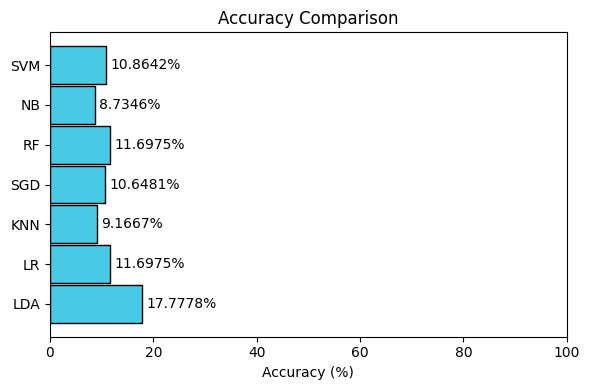

In [111]:
# Perform models on the data with cond_number as y
model_blackbox(merged_df_x, merged_df_y)

For words

In [112]:
# yr_train_combined = Yr['cond_number'] * 100 + Yr['word_number']
yr_combined = (merged_df_y_word['cond_number'] - 2) * 5 + (merged_df_y_word['word_number']-1)
yr_combined

0      42
1      11
2      40
3      41
4      19
       ..
355    17
356    13
357     2
358    48
359    56
Length: 3240, dtype: uint8

LinearDiscriminantAnalysis:		 Accuracy - 3.827160%	, Error Rate - 96.172840%
LogisticRegression:		 Accuracy - 1.172840%	, Error Rate - 98.827160%
KNeighborsClassifier:		 Accuracy - 1.512346%	, Error Rate - 98.487654%
SGDClassifier:		 Accuracy - 1.913580%	, Error Rate - 98.086420%
RandomForestClassifier:		 Accuracy - 2.376543%	, Error Rate - 97.623457%
GaussianNB:		 Accuracy - 2.006173%	, Error Rate - 97.993827%
SVC:		 Accuracy - 0.895062%	, Error Rate - 99.104938%


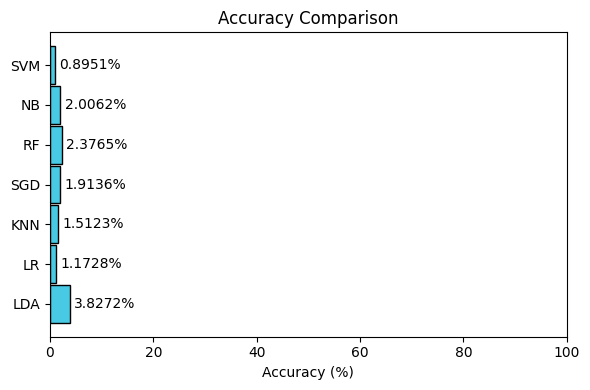

In [113]:
# Perform models on the data with word_number as y
model_blackbox(merged_df_x, yr_combined)

In [114]:
from tensorflow.keras.optimizers import Adam
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop

# optimizer = RMSprop(learning_rate=0.001, rho=0.9)
# optimizer = SGD(learning_rate=0.05, momentum=0.9)
# optimizer = Adagrad(learning_rate=0.01)
# optimizer = Nadam(learning_rate=0.002)
optimizer = Adam(learning_rate=0.001)  

In [115]:

# Assuming you have defined Xr and Yr somewhere in your code

# Assuming Yr is a DataFrame with 'cond_number' and 'word_number' columns
Xr_train, Xr_test, yr_train, yr_test = train_test_split(merged_df_x, merged_df_y_word, test_size=0.1, random_state=42)
print(yr_train['cond_number'].unique())
print(yr_train['word_number'].unique())
def augment_data(X, factor=0.05):
    # Generate random noise
    noise = np.random.normal(0, factor, size=X.shape)
    # Apply random noise to the data
    augmented_X = X + noise
    return augmented_X

# Set the augmentation factor
augmentation_factor = 0.05

# Augment the training data
augmented_Xr_train = augment_data(Xr_train, factor=augmentation_factor)
Xr_train = Xr_train.append(augmented_Xr_train)
print("After augumentation ",augmented_Xr_train.shape)
print("After augumentation ",Xr_train.shape)
# Combine 'cond_number' and 'word_number' columns into a single label
yr_train_combined = (yr_train['cond_number'] - 2) * 5 + (yr_train['word_number']-1)
yr_test_combined = (yr_test['cond_number'] - 2) * 5 + (yr_test['word_number']-1)
# Convert target variable to categorical, and adjust labels to start from 0
num_classes = len(yr_train_combined.unique())
print(num_classes)
# yr_train_categorical = to_categorical(yr_train_combined - yr_train_combined.min(), num_classes=num_classes)
# yr_test_categorical = to_categorical(yr_test_combined - yr_train_combined.min(), num_classes=num_classes)
yr_train_encoded = to_categorical(yr_train_combined, num_classes=60)
yr_test_encoded = to_categorical(yr_test_combined, num_classes=60)

# Create a new model instance to avoid conflicts with the previously defined model
augmented_model = Sequential(
    [
        Dense(117, activation="relu", input_shape=(Xr_train.shape[1],)),
        BatchNormalization(),
        # Dense(512, activation="relu"),
        # BatchNormalization(),
        # Dropout(0.5),
        # Dense(90, activation="relu"),
        # BatchNormalization(),
        # Dropout(0.5),
        Dense(64, activation="relu"),
        BatchNormalization(),
        Dense(num_classes, activation="softmax"),
    ]
)
augmented_model.summary()

# Compile the augmented model with appropriate loss function and metrics
augmented_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Train the augmented model using augmented data
augmented_model.fit(augmented_Xr_train, yr_train_encoded, epochs=25, batch_size=128, validation_split=0.3)

# Evaluate the augmented model on the test set
test_loss_augmented, test_accuracy_augmented = augmented_model.evaluate(Xr_test, yr_test_encoded)
print(f"Test Accuracy (with Data Augmentation): {test_accuracy_augmented}")
# model = Sequential(
#     [
#         Dense(117, activation="relu", input_shape=(Xr_train.shape[1],)),
#         Dense(512, activation="relu"),
#         BatchNormalization(),
#         Dropout(0.5),
#         Dense(90, activation="relu"),
#         BatchNormalization(),
#         Dropout(0.5),
#         Dense(64, activation="relu"),
#         BatchNormalization(),
#         # Dropout(0.5),
#         Dense(num_classes, activation="softmax"),
#     ]
# )
# model.summary()

# # Compile the model with appropriate loss function and metrics
# model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# # Train the model
# model.fit(Xr_train, yr_train_encoded, epochs=25, batch_size=128, validation_split=0.3)

# # Evaluate the model on the test set
# test_loss, test_accuracy = model.evaluate(Xr_test, yr_test_encoded)
# print(f"Test Accuracy: {test_accuracy}")


[ 6 13  4  9  5  7  2  3 11 12  8 10]
[5 3 4 2 1]
After augumentation  (2916, 117)
After augumentation  (5832, 117)
60
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 117)               13806     
                                                                 
 batch_normalization_10 (Bat  (None, 117)              468       
 chNormalization)                                                
                                                                 
 dense_17 (Dense)            (None, 64)                7552      
                                                                 
 batch_normalization_11 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dense_18 (Dense)            (None, 60)                3900      
 

#### Extracting best labels for the categories

In [116]:
Xr = pd.read_csv("merged_df_x_grouped.csv")
Yr = pd.read_csv("merged_df_y_grouped.csv")

In [117]:
Xr.drop("Unnamed: 0", axis=1, inplace=True)
Xr

,Amygdala_L,Amygdala_R,Angular_L,Angular_R,Calcarine_L,Calcarine_R,Caudate_L,Caudate_R,Cerebelum_10_L,Cerebelum_10_R,...,Thalamus_L,Thalamus_R,Vermis_10,Vermis_1_2,Vermis_3,Vermis_4_5,Vermis_6,Vermis_7,Vermis_8,Vermis_9
0,-0.012100,0.127622,0.317062,0.440933,0.982531,1.007493,0.527289,0.697380,-0.452706,0.112530,...,-0.039782,0.046021,-0.402737,-0.304329,0.108593,0.041929,0.218866,0.192530,-0.166507,-0.141913
1,0.184056,-0.252383,0.495670,0.268853,0.541290,0.385210,0.151791,0.061421,-0.137234,-0.151990,...,0.044482,-0.282987,-0.918588,-0.040708,-0.029827,0.101779,0.155766,0.424487,0.118813,0.009467
2,-0.026768,0.080071,0.282150,0.123677,0.316287,0.473524,0.191545,0.268181,0.215842,-0.007734,...,0.229800,0.086662,-0.084191,-0.005997,0.025533,-0.004611,0.339622,0.349004,0.021322,-0.097248
3,0.349658,0.278891,-0.038872,0.051120,0.468914,0.533926,0.302625,0.638368,0.128229,-0.021630,...,0.160389,-0.017670,-0.656971,-0.307707,0.235982,0.038905,0.133213,0.675041,-0.030475,-0.393777
4,0.071451,-0.138541,-0.290449,-0.082056,0.861988,0.837882,0.260126,0.170274,0.251325,0.313872,...,0.324789,0.184883,0.290392,0.159835,0.244467,0.026842,0.410277,0.282093,0.330347,0.219398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3235,0.589885,-0.098256,0.164627,-0.126710,-0.668116,-0.587220,0.786275,0.629815,0.000000,-1.124987,...,0.811939,0.705916,-0.555501,-0.231762,0.534972,0.179561,0.438018,-0.066340,0.119944,-0.602115
3236,-0.947762,0.078449,-0.781387,-0.593179,-1.021776,-0.786649,-1.040937,-1.082501,0.000000,0.127819,...,-0.536765,-0.588264,0.293013,-0.416266,-0.833310,-0.915601,-0.601780,-0.399891,-0.596439,-0.687656
3237,0.891211,0.885160,1.018131,1.172105,1.165504,1.054089,0.573844,0.343005,0.000000,-1.146360,...,0.351170,0.135977,-1.832284,-0.619526,-0.053624,0.613278,0.597363,0.278562,0.253301,-0.709114
3238,-0.518630,-0.951836,-0.579670,-0.520721,-0.753192,-0.687729,0.007167,-0.112834,0.000000,0.468434,...,-0.260458,-0.516816,0.684397,0.774259,-0.224130,-0.581611,-0.170178,-0.241677,-0.390929,-0.080807


In [118]:
Yr.drop("Unnamed: 0", axis=1, inplace=True)
Yr

,cond_number
0,10
1,4
2,10
3,10
4,5
...,...
3235,5
3236,4
3237,2
3238,11


In [119]:
sums = Xr.sum(axis=0)
sums = sums.to_dict()
print(sums)
# sort the dict based on the values in ascending order
# ignore the sign of the values
sorted_sums = sorted(sums.items(), key=lambda x: x[1])
print(sorted_sums)


{'Amygdala_L': -4.507520146600484, 'Amygdala_R': 26.96665482698456, 'Angular_L': -104.00360149792587, 'Angular_R': -187.7718954293535, 'Calcarine_L': 630.0507606075031, 'Calcarine_R': 824.2088982513476, 'Caudate_L': -66.44682049685392, 'Caudate_R': -26.248583922705677, 'Cerebelum_10_L': -15.51571342333094, 'Cerebelum_10_R': -16.90117631457192, 'Cerebelum_3_L': 88.72723580797584, 'Cerebelum_3_R': -28.22558699334889, 'Cerebelum_4_5_L': 404.1104115993047, 'Cerebelum_4_5_R': 115.81581958688619, 'Cerebelum_6_L': 909.0375362034815, 'Cerebelum_6_R': 586.8000622892534, 'Cerebelum_7b_L': 43.89262247600373, 'Cerebelum_7b_R': 256.41532238933377, 'Cerebelum_8_L': 35.498395235951165, 'Cerebelum_8_R': 84.99122683814258, 'Cerebelum_9_L': -228.0850869255148, 'Cerebelum_9_R': -155.17775435113649, 'Cerebelum_Crus1_L': 648.3283918290149, 'Cerebelum_Crus1_R': 355.5641153922881, 'Cerebelum_Crus2_L': -187.77970265158518, 'Cerebelum_Crus2_R': -117.35739108084127, 'Cingulum_Ant_L': -264.8033007849572, 'Cingul

In [120]:
# get the first 60 labels from the sorted sums
labels_to_drop = [label for label, _ in sorted_sums[:85]]
print(labels_to_drop)
# 80-50%
# 85-55%

['Frontal_Sup_Medial_R', 'Cingulum_Ant_R', 'Cingulum_Ant_L', 'Frontal_Med_Orb_R', 'Cerebelum_9_L', 'Cingulum_Post_R', 'Vermis_10', 'Pallidum_R', 'Cerebelum_Crus2_L', 'Angular_R', 'Frontal_Sup_Medial_L', 'SupraMarginal_R', 'Cerebelum_9_R', 'Precuneus_R', 'Frontal_Sup_R', 'Parietal_Inf_R', 'Frontal_Mid_Orb_R', 'Cerebelum_Crus2_R', 'Putamen_R', 'Angular_L', 'Thalamus_R', 'Heschl_R', 'Paracentral_Lobule_R', 'Caudate_L', 'Cingulum_Mid_R', 'Thalamus_L', 'Olfactory_L', 'Frontal_Inf_Orb_R', 'Vermis_3', 'Frontal_Mid_R', 'Pallidum_L', 'Insula_R', 'Putamen_L', 'Vermis_1_2', 'ParaHippocampal_R', 'Cerebelum_3_R', 'Caudate_R', 'Cerebelum_10_R', 'Cerebelum_10_L', 'Vermis_8', 'Cingulum_Mid_L', 'Amygdala_L', 'Temporal_Pole_Mid_R', 'Frontal_Sup_Orb_L', 'Hippocampus_R', 'Paracentral_Lobule_L', 'Temporal_Pole_Mid_L', 'Hippocampus_L', 'Cingulum_Post_L', 'Amygdala_R', 'Olfactory_R', 'Frontal_Sup_Orb_R', 'Temporal_Pole_Sup_R', 'Cerebelum_8_L', 'ParaHippocampal_L', 'Heschl_L', 'Cerebelum_7b_L', 'Rolandic_Oper

In [121]:
Xr.drop(labels_to_drop, axis=1, inplace=True)
Xr

,Calcarine_L,Calcarine_R,Cerebelum_4_5_L,Cerebelum_6_L,Cerebelum_6_R,Cerebelum_Crus1_L,Cerebelum_Crus1_R,Cuneus_L,Cuneus_R,Frontal_Inf_Oper_L,...,Occipital_Sup_R,Parietal_Inf_L,Parietal_Sup_L,Parietal_Sup_R,Postcentral_L,Precentral_L,Supp_Motor_Area_L,Supp_Motor_Area_R,Temporal_Inf_L,Temporal_Inf_R
0,0.982531,1.007493,0.414160,0.983996,0.465675,1.152039,0.732750,0.628767,0.689510,0.887485,...,0.289846,0.764402,0.711166,0.586069,0.121587,0.244611,0.117001,0.298820,0.483019,0.556111
1,0.541290,0.385210,0.376438,0.776264,0.680204,0.836605,0.387679,0.531081,0.370146,0.663989,...,0.132875,0.507264,0.384189,0.175594,-0.007549,0.085910,0.015936,-0.040736,0.107388,0.165341
2,0.316287,0.473524,0.374591,0.390183,0.277416,0.261579,0.232289,0.330022,0.330861,0.662099,...,0.125321,0.426632,0.250430,0.061089,0.083725,0.186331,0.087057,-0.068034,0.021819,0.133259
3,0.468914,0.533926,0.263957,0.634864,0.348780,0.317061,0.279397,0.568922,0.432167,0.581181,...,0.391038,0.416261,0.490523,0.295811,0.317014,0.375085,0.159278,0.277715,0.178203,0.287772
4,0.861988,0.837882,0.472365,0.694258,0.410990,0.320339,0.334668,0.619573,0.580529,0.462756,...,0.264799,0.175838,0.511940,0.463620,0.322040,0.443158,0.427699,0.361326,0.387636,0.448875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3235,-0.668116,-0.587220,0.056712,0.045527,-0.024134,0.151988,0.144343,-0.487446,-0.405722,0.420351,...,-0.140454,0.191152,0.058312,-0.310582,0.173443,0.260793,0.530814,0.721558,-0.021881,-0.044413
3236,-1.021776,-0.786649,-0.810448,-0.901705,-0.762881,-0.958975,-0.646437,-0.615459,-0.628931,-0.334476,...,-0.212730,-0.485124,-0.372904,-0.717698,-0.231019,-0.137242,-0.175077,-0.761923,-0.309609,-0.500749
3237,1.165504,1.054089,0.919646,1.047349,0.834596,0.899632,0.783979,1.239498,1.377018,1.216541,...,0.982473,1.092302,1.558199,1.221806,1.066318,0.901385,0.756254,1.324815,0.976300,0.999533
3238,-0.753192,-0.687729,-0.621330,-0.250212,-0.350712,-0.095933,-0.028146,-0.656222,-0.748736,0.278564,...,-0.438760,-0.124129,-0.308322,-0.243454,-0.173026,-0.105100,-0.014517,-0.396767,-0.199022,-0.280661


LinearDiscriminantAnalysis:		 Accuracy - 15.740741%	, Error Rate - 84.259259%


LogisticRegression:		 Accuracy - 11.481481%	, Error Rate - 88.518519%
KNeighborsClassifier:		 Accuracy - 11.080247%	, Error Rate - 88.919753%
SGDClassifier:		 Accuracy - 11.481481%	, Error Rate - 88.518519%
RandomForestClassifier:		 Accuracy - 12.993827%	, Error Rate - 87.006173%
GaussianNB:		 Accuracy - 9.475309%	, Error Rate - 90.524691%
SVC:		 Accuracy - 12.716049%	, Error Rate - 87.283951%


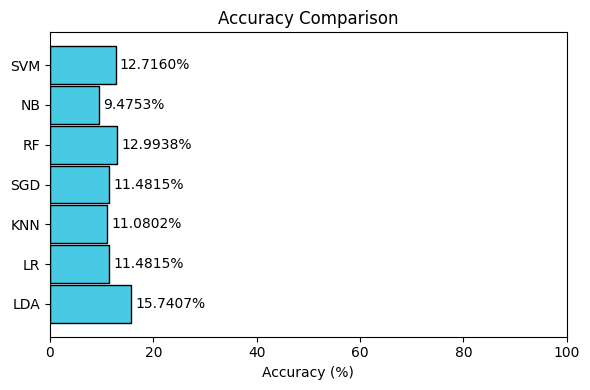

In [122]:
# Perform models on the data with cond_number as y after dropping the columns
model_blackbox(Xr, Yr)

#### Extracting best labels for the words

In [123]:
Xr = pd.read_csv("merged_df_x_grouped.csv")
Yr = pd.read_csv("merged_df_y_word_grouped.csv")

In [124]:
Xr.drop("Unnamed: 0", axis=1, inplace=True)
Xr

,Amygdala_L,Amygdala_R,Angular_L,Angular_R,Calcarine_L,Calcarine_R,Caudate_L,Caudate_R,Cerebelum_10_L,Cerebelum_10_R,...,Thalamus_L,Thalamus_R,Vermis_10,Vermis_1_2,Vermis_3,Vermis_4_5,Vermis_6,Vermis_7,Vermis_8,Vermis_9
0,-0.012100,0.127622,0.317062,0.440933,0.982531,1.007493,0.527289,0.697380,-0.452706,0.112530,...,-0.039782,0.046021,-0.402737,-0.304329,0.108593,0.041929,0.218866,0.192530,-0.166507,-0.141913
1,0.184056,-0.252383,0.495670,0.268853,0.541290,0.385210,0.151791,0.061421,-0.137234,-0.151990,...,0.044482,-0.282987,-0.918588,-0.040708,-0.029827,0.101779,0.155766,0.424487,0.118813,0.009467
2,-0.026768,0.080071,0.282150,0.123677,0.316287,0.473524,0.191545,0.268181,0.215842,-0.007734,...,0.229800,0.086662,-0.084191,-0.005997,0.025533,-0.004611,0.339622,0.349004,0.021322,-0.097248
3,0.349658,0.278891,-0.038872,0.051120,0.468914,0.533926,0.302625,0.638368,0.128229,-0.021630,...,0.160389,-0.017670,-0.656971,-0.307707,0.235982,0.038905,0.133213,0.675041,-0.030475,-0.393777
4,0.071451,-0.138541,-0.290449,-0.082056,0.861988,0.837882,0.260126,0.170274,0.251325,0.313872,...,0.324789,0.184883,0.290392,0.159835,0.244467,0.026842,0.410277,0.282093,0.330347,0.219398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3235,0.589885,-0.098256,0.164627,-0.126710,-0.668116,-0.587220,0.786275,0.629815,0.000000,-1.124987,...,0.811939,0.705916,-0.555501,-0.231762,0.534972,0.179561,0.438018,-0.066340,0.119944,-0.602115
3236,-0.947762,0.078449,-0.781387,-0.593179,-1.021776,-0.786649,-1.040937,-1.082501,0.000000,0.127819,...,-0.536765,-0.588264,0.293013,-0.416266,-0.833310,-0.915601,-0.601780,-0.399891,-0.596439,-0.687656
3237,0.891211,0.885160,1.018131,1.172105,1.165504,1.054089,0.573844,0.343005,0.000000,-1.146360,...,0.351170,0.135977,-1.832284,-0.619526,-0.053624,0.613278,0.597363,0.278562,0.253301,-0.709114
3238,-0.518630,-0.951836,-0.579670,-0.520721,-0.753192,-0.687729,0.007167,-0.112834,0.000000,0.468434,...,-0.260458,-0.516816,0.684397,0.774259,-0.224130,-0.581611,-0.170178,-0.241677,-0.390929,-0.080807


In [125]:
Yr.drop("Unnamed: 0", axis=1, inplace=True)
Yr

,cond_number,word_number
0,10,3
1,4,2
2,10,1
3,10,2
4,5,5
...,...,...
3235,5,3
3236,4,4
3237,2,3
3238,11,4


In [126]:
sums = Xr.sum(axis=0)
sums = sums.to_dict()
print(sums)
# sort the dict based on the values in ascending order
# ignore the sign of the values
sorted_sums = sorted(sums.items(), key=lambda x: x[1])
print(sorted_sums)


{'Amygdala_L': -4.507520146600484, 'Amygdala_R': 26.96665482698456, 'Angular_L': -104.00360149792587, 'Angular_R': -187.7718954293535, 'Calcarine_L': 630.0507606075031, 'Calcarine_R': 824.2088982513476, 'Caudate_L': -66.44682049685392, 'Caudate_R': -26.248583922705677, 'Cerebelum_10_L': -15.51571342333094, 'Cerebelum_10_R': -16.90117631457192, 'Cerebelum_3_L': 88.72723580797584, 'Cerebelum_3_R': -28.22558699334889, 'Cerebelum_4_5_L': 404.1104115993047, 'Cerebelum_4_5_R': 115.81581958688619, 'Cerebelum_6_L': 909.0375362034815, 'Cerebelum_6_R': 586.8000622892534, 'Cerebelum_7b_L': 43.89262247600373, 'Cerebelum_7b_R': 256.41532238933377, 'Cerebelum_8_L': 35.498395235951165, 'Cerebelum_8_R': 84.99122683814258, 'Cerebelum_9_L': -228.0850869255148, 'Cerebelum_9_R': -155.17775435113649, 'Cerebelum_Crus1_L': 648.3283918290149, 'Cerebelum_Crus1_R': 355.5641153922881, 'Cerebelum_Crus2_L': -187.77970265158518, 'Cerebelum_Crus2_R': -117.35739108084127, 'Cingulum_Ant_L': -264.8033007849572, 'Cingul

In [127]:
# get the first 60 labels from the sorted sums
labels_to_drop = [label for label, _ in sorted_sums[:85]]
print(labels_to_drop)
# 80-50%
# 85-55%

['Frontal_Sup_Medial_R', 'Cingulum_Ant_R', 'Cingulum_Ant_L', 'Frontal_Med_Orb_R', 'Cerebelum_9_L', 'Cingulum_Post_R', 'Vermis_10', 'Pallidum_R', 'Cerebelum_Crus2_L', 'Angular_R', 'Frontal_Sup_Medial_L', 'SupraMarginal_R', 'Cerebelum_9_R', 'Precuneus_R', 'Frontal_Sup_R', 'Parietal_Inf_R', 'Frontal_Mid_Orb_R', 'Cerebelum_Crus2_R', 'Putamen_R', 'Angular_L', 'Thalamus_R', 'Heschl_R', 'Paracentral_Lobule_R', 'Caudate_L', 'Cingulum_Mid_R', 'Thalamus_L', 'Olfactory_L', 'Frontal_Inf_Orb_R', 'Vermis_3', 'Frontal_Mid_R', 'Pallidum_L', 'Insula_R', 'Putamen_L', 'Vermis_1_2', 'ParaHippocampal_R', 'Cerebelum_3_R', 'Caudate_R', 'Cerebelum_10_R', 'Cerebelum_10_L', 'Vermis_8', 'Cingulum_Mid_L', 'Amygdala_L', 'Temporal_Pole_Mid_R', 'Frontal_Sup_Orb_L', 'Hippocampus_R', 'Paracentral_Lobule_L', 'Temporal_Pole_Mid_L', 'Hippocampus_L', 'Cingulum_Post_L', 'Amygdala_R', 'Olfactory_R', 'Frontal_Sup_Orb_R', 'Temporal_Pole_Sup_R', 'Cerebelum_8_L', 'ParaHippocampal_L', 'Heschl_L', 'Cerebelum_7b_L', 'Rolandic_Oper

In [128]:
Xr.drop(labels_to_drop, axis=1, inplace=True)
Xr

,Calcarine_L,Calcarine_R,Cerebelum_4_5_L,Cerebelum_6_L,Cerebelum_6_R,Cerebelum_Crus1_L,Cerebelum_Crus1_R,Cuneus_L,Cuneus_R,Frontal_Inf_Oper_L,...,Occipital_Sup_R,Parietal_Inf_L,Parietal_Sup_L,Parietal_Sup_R,Postcentral_L,Precentral_L,Supp_Motor_Area_L,Supp_Motor_Area_R,Temporal_Inf_L,Temporal_Inf_R
0,0.982531,1.007493,0.414160,0.983996,0.465675,1.152039,0.732750,0.628767,0.689510,0.887485,...,0.289846,0.764402,0.711166,0.586069,0.121587,0.244611,0.117001,0.298820,0.483019,0.556111
1,0.541290,0.385210,0.376438,0.776264,0.680204,0.836605,0.387679,0.531081,0.370146,0.663989,...,0.132875,0.507264,0.384189,0.175594,-0.007549,0.085910,0.015936,-0.040736,0.107388,0.165341
2,0.316287,0.473524,0.374591,0.390183,0.277416,0.261579,0.232289,0.330022,0.330861,0.662099,...,0.125321,0.426632,0.250430,0.061089,0.083725,0.186331,0.087057,-0.068034,0.021819,0.133259
3,0.468914,0.533926,0.263957,0.634864,0.348780,0.317061,0.279397,0.568922,0.432167,0.581181,...,0.391038,0.416261,0.490523,0.295811,0.317014,0.375085,0.159278,0.277715,0.178203,0.287772
4,0.861988,0.837882,0.472365,0.694258,0.410990,0.320339,0.334668,0.619573,0.580529,0.462756,...,0.264799,0.175838,0.511940,0.463620,0.322040,0.443158,0.427699,0.361326,0.387636,0.448875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3235,-0.668116,-0.587220,0.056712,0.045527,-0.024134,0.151988,0.144343,-0.487446,-0.405722,0.420351,...,-0.140454,0.191152,0.058312,-0.310582,0.173443,0.260793,0.530814,0.721558,-0.021881,-0.044413
3236,-1.021776,-0.786649,-0.810448,-0.901705,-0.762881,-0.958975,-0.646437,-0.615459,-0.628931,-0.334476,...,-0.212730,-0.485124,-0.372904,-0.717698,-0.231019,-0.137242,-0.175077,-0.761923,-0.309609,-0.500749
3237,1.165504,1.054089,0.919646,1.047349,0.834596,0.899632,0.783979,1.239498,1.377018,1.216541,...,0.982473,1.092302,1.558199,1.221806,1.066318,0.901385,0.756254,1.324815,0.976300,0.999533
3238,-0.753192,-0.687729,-0.621330,-0.250212,-0.350712,-0.095933,-0.028146,-0.656222,-0.748736,0.278564,...,-0.438760,-0.124129,-0.308322,-0.243454,-0.173026,-0.105100,-0.014517,-0.396767,-0.199022,-0.280661


In [129]:
# yr_train_combined = Yr['cond_number'] * 100 + Yr['word_number']
yr_combined = (Yr['cond_number'] - 2) * 5 + (Yr['word_number']-1)
yr_combined

0       42
1       11
2       40
3       41
4       19
        ..
3235    17
3236    13
3237     2
3238    48
3239    56
Length: 3240, dtype: int64

In [130]:
print(len(np.unique(yr_train_combined)))

60


In [131]:
from tensorflow.keras.optimizers import Adam
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

optimizer = Adam(learning_rate=0.005)  

In [132]:

# Assuming you have defined Xr and Yr somewhere in your code

# Assuming Yr is a DataFrame with 'cond_number' and 'word_number' columns
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, Yr, test_size=0.1, random_state=42)
print(yr_train['cond_number'].unique())
print(yr_train['word_number'].unique())

# Combine 'cond_number' and 'word_number' columns into a single label
yr_train_combined = (yr_train['cond_number'] - 2) * 5 + (yr_train['word_number']-1)
yr_test_combined = (yr_test['cond_number'] - 2) * 5 + (yr_test['word_number']-1)
# Convert target variable to categorical, and adjust labels to start from 0
num_classes = len(yr_train_combined.unique())
print(num_classes)
# yr_train_categorical = to_categorical(yr_train_combined - yr_train_combined.min(), num_classes=num_classes)
# yr_test_categorical = to_categorical(yr_test_combined - yr_train_combined.min(), num_classes=num_classes)
yr_train_encoded = to_categorical(yr_train_combined, num_classes=60)
yr_test_encoded = to_categorical(yr_test_combined, num_classes=60)

model = Sequential(
    [
        Dense(32, activation="relu", input_shape=(Xr_train.shape[1],)),
        Dense(64, activation="relu"),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation="relu"),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation="softmax"),
    ]
)
model.summary()

# Compile the model with appropriate loss function and metrics
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
model.fit(Xr_train, yr_train_encoded, epochs=50, batch_size=64, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(Xr_test, yr_test_encoded)
print(f"Test Accuracy: {test_accuracy}")


[ 6 13  4  9  5  7  2  3 11 12  8 10]
[5 3 4 2 1]
60
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 32)                1056      
                                                                 
 dense_20 (Dense)            (None, 64)                2112      
                                                                 
 batch_normalization_12 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 256)               16640     
                                                                 
 batch_normalization_13 (Bat  (None, 256)              1024      
 

In [133]:

# # Assuming you have defined Xr and Yr somewhere in your code

# # Assuming Yr is a DataFrame with 'cond_number' and 'word_number' columns
# Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, Yr, test_size=0.1, random_state=42)
# print(yr_train['cond_number'].unique())
# print(yr_train['word_number'].unique())

# # Combine 'cond_number' and 'word_number' columns into a single label
# yr_train_combined = (yr_train['cond_number'] - 2) * 5 + (yr_train['word_number']-1)
# yr_test_combined = (yr_test['cond_number'] - 2) * 5 + (yr_test['word_number']-1)
# # Convert target variable to categorical, and adjust labels to start from 0
# num_classes = len(yr_train_combined.unique())
# print(num_classes)
# # yr_train_categorical = to_categorical(yr_train_combined - yr_train_combined.min(), num_classes=num_classes)
# # yr_test_categorical = to_categorical(yr_test_combined - yr_train_combined.min(), num_classes=num_classes)
# yr_train_encoded = to_categorical(yr_train_combined, num_classes=60)
# yr_test_encoded = to_categorical(yr_test_combined, num_classes=60)

# model = Sequential(
#     [
#         Dense(32, activation="relu", input_shape=(Xr_train.shape[1],)),
#         Dense(64, activation="relu"),
#         Dense(256, activation="relu"),
#         Dense(128, activation="relu"),
#         Dense(num_classes, activation="softmax"),
#     ]
# )
# model.summary()

# # Compile the model with appropriate loss function and metrics
# model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# # Train the model
# model.fit(Xr_train, yr_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

# # Evaluate the model on the test set
# test_loss, test_accuracy = model.evaluate(Xr_test, yr_test_encoded)
# print(f"Test Accuracy: {test_accuracy}")


LinearDiscriminantAnalysis:		 Accuracy - 3.487654%	, Error Rate - 96.512346%
LogisticRegression:		 Accuracy - 1.358025%	, Error Rate - 98.641975%
KNeighborsClassifier:		 Accuracy - 2.469136%	, Error Rate - 97.530864%
SGDClassifier:		 Accuracy - 1.790123%	, Error Rate - 98.209877%
RandomForestClassifier:		 Accuracy - 2.623457%	, Error Rate - 97.376543%
GaussianNB:		 Accuracy - 2.006173%	, Error Rate - 97.993827%
SVC:		 Accuracy - 1.296296%	, Error Rate - 98.703704%


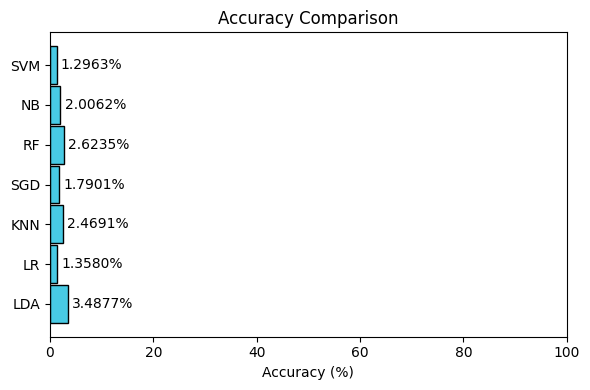

In [134]:
# Perform models on the data with word_number as y after dropping the columns
model_blackbox(Xr, yr_combined)